In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm
import experiments.rbm as exp_rbm

# Load

In [89]:
n = 500
dim = 1
res_stats = pickle.load(open(f"../data/weight/stats_n{n}_d{dim}.pkl", "rb"))

b_ls = list(res_stats.keys())
print(b_ls)
ol = list(res_stats[b_ls[0]].keys())[0]
print(ol)
eps_ls = list(res_stats[b_ls[0]][ol].keys())
print(eps_ls)

[0.25, 0.5, 1.0]
10.0
[0.0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [99]:
eps_ls = eps_ls[:11]

In [100]:
plot_df_ls = {}

methods = {"tilted": "Tilted"}

plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": [], "b": []}

for eps in eps_ls:
    rr = res_stats[b_ls[0]][ol][eps]["standard"]
    plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
    plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
    plot_df["rej"].extend(rr["rej"])
    plot_df["b"].extend([0.] * len(rr["nonsq_stat"]))
    plot_df["method"].extend(["IMQ"] * len(rr["nonsq_stat"]))

for b in b_ls:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[b][ol][eps][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["b"].extend([str(b)] * len(rr["nonsq_stat"]))
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

plot_df = pd.DataFrame(plot_df)

In [109]:
# stein kernel plot
X = jnp.reshape(jnp.linspace(-3., 3., 1001), (-1, 1))

ksd_vals_ls = []

score_fn = lambda x: -x

# IMQ
kernel = kernels.IMQ(sigma_sq=2*1.)
ksd_imq = metrics.KSD(kernel, score_fn=score_fn)

ksd_imq_vals = np.diagonal(ksd_imq(X, X, vstat=True, output_dim=2))
ksd_vals_ls.append(ksd_imq_vals)

# R-KSD boot
score = score_fn(X)
hvp = - score

for b in b_ls:
    score_weight_fn = kernels.PolyWeightFunction(b=b)
    kernel0 = kernels.IMQ(sigma_sq=2*1.)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    ksd_tilted = metrics.KSD(kernel)
    
    ksd_tilted_vals = np.diagonal(ksd_tilted(X, X, vstat=True, output_dim=2, score=score, hvp=hvp))
    ksd_vals_ls.append(ksd_tilted_vals)

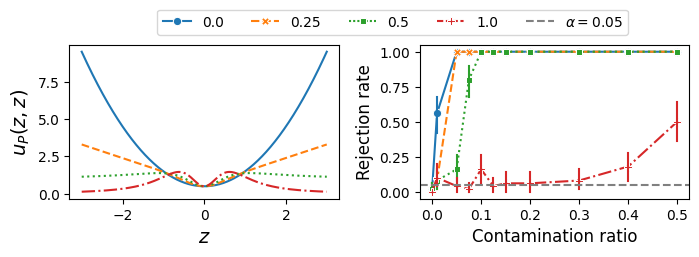

In [159]:
_, axes = plt.subplots(ncols=2, figsize=(8, 2))

# stein kernel
ax = axes[0]
linestyles = ["solid", "dashed", "dotted", "dashdot"]

for i, b in enumerate(plot_df.b.unique()):
    ksd_vals = ksd_vals_ls[i]
    ax.plot(np.reshape(X, -1), ksd_vals, label=f"{b}", linestyle=linestyles[i])
ax.set_xlabel(r"$z$", fontsize=14)
ax.set_ylabel(r"$u_P(z, z)$", fontsize=14)
# ax.legend(title="b")

# rej probs
ax = axes[1]
_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="b", style="b", markers=True, err_style="bars")
# markers = ["o", "x", "s", "+"]
# for b, marker in zip(plot_df.b.unique(), markers):
#     rej_mean = plot_df.loc[plot_df.b == b, ["eps", "rej"]].groupby("eps").mean()
#     ax.scatter(eps_ls, rej_mean, marker=marker)

ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
for i in range(len(plot_df.b.unique())):
    ax.lines[2*i].set_linestyle(linestyles[i])
ax.set_xlabel("Contamination ratio", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)
ax.legend([],[], frameon=False)

# ax.legend()
lgd = axes[1].legend(bbox_to_anchor=(-1., 1.02, 1, 0.2), loc="lower left", ncol=5)

plt.subplots_adjust(wspace=0.3)
# plt.savefig("../figs/robust/stein_kernels.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [93]:
# X_res = pickle.load(open(f"../data/weight/X_res_n{n}_d{dim}.pkl", "rb"))

In [88]:
# X = X_res[ol][0.05][0]

# _ = plt.hist(X[:, 3], bins=20)